In [110]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
ppp = pd.read_csv('../data/cleaned_1and2_reduced.csv')
ppp.head()

,SBAOfficeCode,ProcessingMethod,BorrowerCity,BorrowerState,BorrowerZip,LoanStatus,Term,SBAGuarantyPercentage,InitialApprovalAmount,CurrentApprovalAmount,...,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED,BusinessType,OriginatingLenderLocationID,Gender,Veteran
0,156,PPP,NORWALK,CT,06853-1207,Paid in Full,24,100,18457.00,18457.00,...,18457.00,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),9551,Unanswered,Unanswered
1,156,PPP,WEST HARTFORD,CT,06107-2103,Paid in Full,24,100,18457.00,18457.00,...,18457.00,0.0,0.0,0.0,0.0,0.0,Corporation,9551,Female Owned,Unanswered
2,156,PPS,Ashford,CT,06278-1421,Paid in Full,60,100,18456.65,18456.65,...,18450.65,0.0,0.0,0.0,0.0,0.0,Limited Liability Company(LLC),93682,Female Owned,Non-Veteran
3,156,PPP,Niantic,CT,06357-1742,Paid in Full,60,100,18456.00,18456.00,...,18455.00,0.0,0.0,0.0,0.0,0.0,Single Member LLC,93490,Male Owned,Non-Veteran
4,156,PPP,Newington,CT,06111-2212,Paid in Full,60,100,18455.00,18455.00,...,18455.00,0.0,0.0,0.0,0.0,0.0,Corporation,529111,Unanswered,Unanswered


In [46]:
# ppp['BusinessType']

subset_cols.append('BusinessType')

In [47]:
subset_cols

['LoanStatus', 'Term', 'SBAGuarantyPercentage', 'BusinessType']

In [54]:
# To speed up computation, reduce the dimensionality
subset_cols = ppp.columns[5:8].to_list()
subset_cols.append('BusinessType')
# subset_cols
subset_ppp = ppp[subset_cols]

In [56]:
subset_ppp.columns

Index(['LoanStatus', 'Term', 'SBAGuarantyPercentage', 'BusinessType'], dtype='object')

In [87]:
# Define X and y
X = subset_ppp.drop(columns=['LoanStatus'])
y = subset_ppp['LoanStatus']

In [88]:
y.value_counts(normalize=True)

LoanStatus
Paid in Full    0.908000
Charged Off     0.062203
Exemption 4     0.029797
Name: proportion, dtype: float64

### Preprocessing 
#### OneHotEncoder to dummify the categorical features

In [95]:
# Make a list of categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

In [90]:
len(subset_ppp['BusinessType'].unique())

26

In [96]:
# Preprocessing pipeline for categorical features
preprocessor = ColumnTransformer(transformers=[
    ('oh', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)  
])

In [97]:
# Define the Random Forest model with preprocessing and classifier
# Use default tuning parameters
rf = RandomForestClassifier(n_estimators=5, max_depth=3, )

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rf', rf)
])

In [98]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [99]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessType']),
                                                 ('num', StandardScaler(),
                                                  ['Term',
                                                   'SBAGuarantyPercentage'])])),
                ('rf', RandomForestClassifier(max_depth=3, n_estimators=5))])

In [100]:
pipe.score(X_train, y_train)

0.9095325291780372

In [101]:
pipe.score(X_test, y_test)

0.9091903039138126

In [108]:
# Reassemble the feature names so that we can map these correctly to feature importances

transformed_feature_names = pipe.named_steps['preprocessor'] \
                                 .named_transformers_['oh'] \
                                 .get_feature_names_out(categorical_cols).tolist()
all_feature_names = transformed_feature_names + numerical_cols
all_feature_names

['BusinessType_501(c) – Non Profit except 3,4,6,',
 'BusinessType_501(c)19 – Non Profit Veterans',
 'BusinessType_501(c)3 – Non Profit',
 'BusinessType_501(c)6 – Non Profit Membership',
 'BusinessType_Cooperative',
 'BusinessType_Corporation',
 'BusinessType_Employee Stock Ownership Plan(ESOP)',
 'BusinessType_Housing Co-op',
 'BusinessType_Independent Contractors',
 'BusinessType_Joint Venture',
 'BusinessType_Limited  Liability Company(LLC)',
 'BusinessType_Limited Liability Partnership',
 'BusinessType_Non-Profit Childcare Center',
 'BusinessType_Non-Profit Organization',
 'BusinessType_Partnership',
 'BusinessType_Professional Association',
 'BusinessType_Qualified Joint-Venture (spouses)',
 'BusinessType_Rollover as Business Start-Ups (ROB',
 'BusinessType_Self-Employed Individuals',
 'BusinessType_Single Member LLC',
 'BusinessType_Sole Proprietorship',
 'BusinessType_Subchapter S Corporation',
 'BusinessType_Tenant in Common',
 'BusinessType_Tribal Concerns',
 'BusinessType_Trus

In [102]:
# Get feature importances from the trained model
feature_importances = pipe.named_steps['rf'].feature_importances_
len(feature_importances)

28

In [109]:
# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
top_features = importance_df.sort_values(by='Importance', ascending=False)
top_features

,Feature,Importance
26,Term,0.599361
5,BusinessType_Corporation,0.257735
18,BusinessType_Self-Employed Individuals,0.070545
21,BusinessType_Subchapter S Corporation,0.022834
20,BusinessType_Sole Proprietorship,0.015110
13,BusinessType_Non-Profit Organization,0.014858
8,BusinessType_Independent Contractors,0.012170
15,BusinessType_Professional Association,0.004935
11,BusinessType_Limited Liability Partnership,0.002451
0,"BusinessType_501(c) – Non Profit except 3,4,6,",0.000000


In [115]:
# Examine y predictions
y_pred = pipe.predict(X_test)
pd.Series(y_pred).value_counts(normalize=True)

Paid in Full    0.998213
Charged Off     0.001787
Name: proportion, dtype: float64

In [116]:
# Examine the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [117]:
print(cm)

[[   727      0  27258]
 [     4      0  13529]
 [    73      0 408405]]


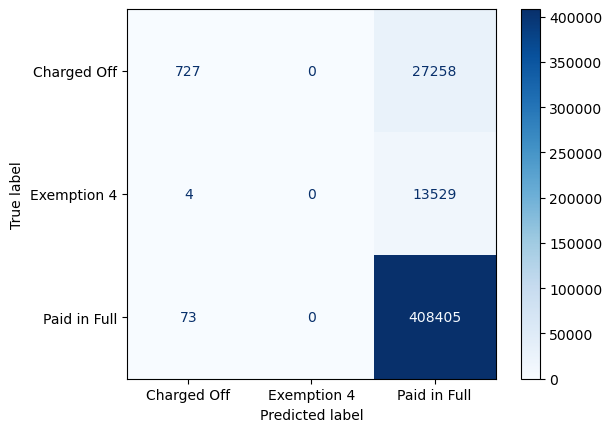

In [118]:
ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Blues');

In [122]:
# Compute overall accuracy from confusion matrix
overall_accuracy = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / cm.sum()
round(overall_accuracy, 3)

0.909

In [128]:
# Calculate precision, recall, and F1-score for each class
precision = cm.diagonal() / (cm.sum(axis=0) + 1)
recall = cm.diagonal() / (cm.sum(axis=1) + 1)
# f1_score = 2 * (precision * recall) / (precision + recall)

/var/folders/l7/qw8k931d3z54gh33d0gmyz7c0000gn/T/ipykernel_8190/765228171.py:4: RuntimeWarning: invalid value encountered in divide
  f1_score = 2 * (precision * recall) / (precision + recall)


In [126]:
print(f"Overall Accuracy: {overall_accuracy:.4f}")
# print(f"Baseline Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall (Sensitivity): {recall}")
print(f"F1-Score: {f1_score}")

Overall Accuracy: 0.9092
Precision: [0.90310559 0.         0.90919716]
Recall (Sensitivity): [0.02597727 0.         0.99981884]
F1-Score: [0.0505054       nan 0.9523593]


In [129]:
cm.diagonal()

array([   727,      0, 408405])

### We must understand how these metrics work for multi-class target feature
Imbalanced classes are a most important concern.
When we understand precision and recall, in addition to accuracy, we can then appropriately adjust our model to improve performance.

# TO-DO >>>

~~collapse target into binary~~

holdout - best practices 
split train val test 80 10 10

add all numeric
exclude categorical vals where there are too many unique values

how to narrow down cat cols:
1) engineer feature to reduce number of unique values by doing top 5, and 'other'
2) ordinal labeling
3) examine feature importance and drop least important, then retrain



cross-validation -- why do we do this

downsample until it finishes

no need to boostrap resample, sufficient to binarize

Google colab for scale up

# models to try
0) RandomForest
1) XGBoost
2) knn
3) SVM
4) Multilayer perceptron NN - fewer hyperparameters
5) --NN keras